In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

<div class="alert alert-block alert-success">
    <b>Tip</b> 

My lecture notebooks to date have been cluttered with inline code.
This can obscure the message.

From now on: putting all my code in a module so that the notebook is more focussed.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

# Overview

## Goals

- Better understand Transformations
- Understand what the coefficients in Linear Regression mean
- Some pitfalls of Categoriacal Features in Linear Regression
- Optimization of the objective function
      
    

## Plan

- We revisit Synthesizing Features, a type of Feature Engineering
- In the previous lecture we introduced Transformations
    - We motivated Transformations via the need for a Scaling transformation when using KNN
    - We continue motivating other transformations (mainly in the context of Linear models)
        - range reduction: influential points
        - normality inducing transformations
- Transformations may be applied either to the Features or Targets or both
- We examine what the coefficients in Linear models are telling us
    - Particular attention t Categorial features
 

# Linear Regression: Matrix form refresher

We have been writing our linear models as either

$
\hat{y} = \theta_0 + \sum_{i=1}^n { \theta_i \cdot x_i }
$

or in matrix form

$
y = \Theta^T \cdot X
$

for 
- column vector $y$
- column vector of coefficients $\Theta$
- feature matrix $X$

Let's be very clear about dimensions
- $y$ is of length $m$, the number of observations
- $\Theta$ is of length $n + 1$, since $\Theta = [ \theta_0, \ldots, \theta_n ]$
- X is of dimension $(m, n+1)$
    - one row per observation
    - row $i$ of X is the feature vector for the $i^{th}$ observation
    - element $i$ of y is the value of the target for the $i^{th}$ observation
    - the first column of $X$ is a column of $1$'s, corresponding to the intercept

# Transformations continued: synthesized features
[Geron housing data](external/handson-ml/02_end_to_end_machine_learning_project.ipynb#Get-the-data)
 

## Data: California Housing Prices Data (AG Chapt 2)

In [3]:
housing = tm.load_housing_data()
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents a district

Goal is to predict Median House Value in the district.

- Features
    - total_rooms: number of rooms in the district
    - total_bedrooms: number of bedrooms in the district
    - households; number of households in the district
    - population: number of people in the district
    - median_income: median income of people in the district
    - 
- Target
    - median_house_value: median value of a house in the district

What potential issues pop out ?

Some *raw* features depend on the *size* of the district, so can't compare the same feature across districts.

- total_rooms, total_bedrooms, households, population 


### Feature engineering: transform to meaningful features

In [4]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

By synthesizing ratios:
- rooms/household
- population/household
- bedrooms/room

we have transformed the raw features into processed features that will probably be better predictors


### Feature engineering: bucketing and clipping

- Will $1 more of income *really* predict higher housing prices in the district ?
    - create income buckets
        - Disclaimer
            - In the book this is **not** a feature but something used to "stratify" the sample
            - We are taking a bit of artistic license to make a point

In [5]:
print("Median income ranges from {min:.1f} to {max:.1f}".format(min=housing["median_income"].min(), 
                                                                max=housing["median_income"].max()
                                                               ))
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

print("Income buckets")
housing["income_cat"].value_counts()

Median income ranges from 0.5 to 15.0
Income buckets


3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

Still a lot of buckets.  One theory is that incomes above bucket 5 don't predict housing prices, so clip.

In [6]:
# Label those above 5 as 5
housing["income_cat_clipped"] = housing["income_cat"].where(housing["income_cat"] < 5, 5.0)
print("Income buckets")
housing["income_cat_clipped"].value_counts()

Income buckets


3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat_clipped, dtype: int64

# Transformations continued: the importance of scaling

<div class="alert alert-block alert-warning">
<ul>
    <li>We continue to use Linear models to make our points.</li>
    <li>It's important to emphasize once more that some of these points generalize to other models, and some don't</li>
    <li>Linear models are sufficiently useful that we will invest the time even in the cases where the points don't fully generalize</li>
    
 </ul>
 
</div>

## Stretched datasets: KNN affected, Decision Trees not

Recall our previous example illustrating how some models are affected/unaffected by scaling transformations:
- "Stretch" Feature 1 (multiply by 10)
- Nearest neighbors is affected
- Decision Tree is not

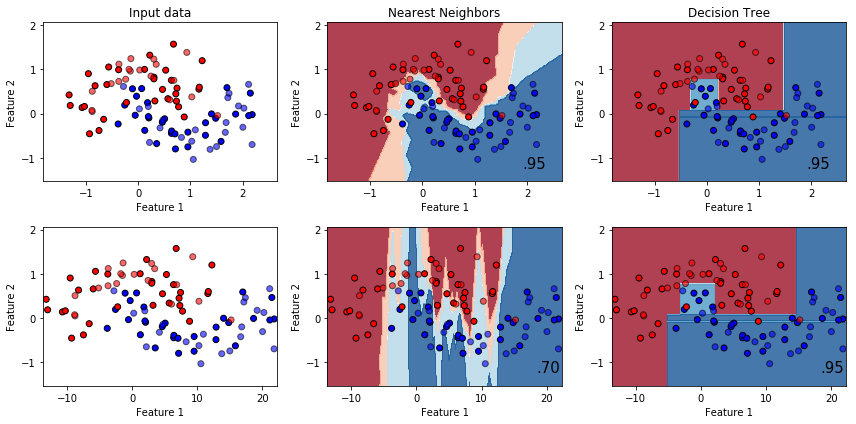

In [7]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=False, num_ds=2)

## Features with extreme values: Influential points

We enumerated a number of transformations whose objective was to reduce the range of values for a feature.
Reasons
- put multiple features on same scale
- reduce the influence of extreme observations

Transformations
- Standardize
- MinMax


### Influential points

Some models may be quite sensitive to just a few observations, including Regression.

Loosely speaking, an observation is **influential** if the parameter estimate $\Theta$ changes greatly depending on whether the observation is included/excluded

The **leverage** of an observation is related to the value of a feature in relation to the mean (across observations) of the feature
- extreme values of the feature have higher leverage

It is not always the case, but high leverage sometimes makes the point influential

Influence of a point is a function of its leverage and how far its target is from the mean across targets of other observations.

We will gain some intuition (hopefully) through the following interactive tool, which changes a single observation and refits a Linear model.
- x: slider to control the index of the point being changed (left-most point is index 1; right-most is 10)
- y: slider to control how much the target of the observation chosen is to be changed

In [8]:
iph = tmh.InfluentialHelper()

x,y = iph.setup()
iph.show_slider()

interactive(children=(IntSlider(value=5, description='x_l', max=9), IntSlider(value=0, description='y_l', max=…

# Normality inducing transformations

Recall that, for `LogisticRegression` we transformed the target from a probability (binary target, a 0/1 value)
to log odds.

- Note: target Survived/Not Survived is treated as a probability and has value of either 0 or 1

Consider the following Linear models to predict probability of Surviving Titanic
- $ p^{(i)} = \Theta^T \cdot x^{(i)}$
    - $p$ is not normally distributed, so hard for errors of linear model to be normal
- $ { { p^{(i)} } \over { 1 -p^{(i)}} } = \Theta^T \cdot x^{(i)}$
    - odds are not normally distributed either
-  $ { \text{log}  {{ p^{(i)}  } \over { 1 -p^{(i)}} } } = \Theta^T \cdot x^{(i)}$
    - log odds *is* normally distributed as we show below
    

    

So by synthesizing the target (the odds) and performing a Log transformation, we have a target that satisfies the
assumptions of a Linear model.

<div class="alert alert-block alert-warning">
<ul>
    <li> Loose Language Alert
    </ul>
</div>

- $ { { p^{(i)} } \over { 1 -p^{(i)}} } $ is called **odds**
- if I have two odds $O_i$ and $O_j$, then $ O_i \over O_j$ is called an **odds ratio**

I may have been sloppy in calling "odds" the "odds ratio"

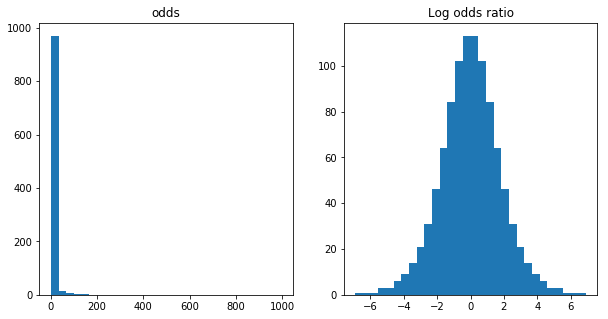

In [9]:
tf = tmh.TransformHelper()
tf.plot_odds()

# Interpretting the coefficients in Linear Models

This section applies only to Linear models (`LinearRegression`, `LogisticRegression`)

It may seem overly specialized, but since these models are used so often, we will spend some time.

Also, because we can assign a meaning to the coefficients, these models are highly interpretable.

## Numeric features
For Linear Regression

$
\hat{y^{(i)}} =  \Theta \cdot x^{(i)} = \sum_{j=1} { \theta_j * x^{(i)}_j }
$

so for a *unit* change in $x^{(i)}_j, \Delta x^{(i)}_j $

$
\Delta \hat{y^{(i)}}  =  \theta_j \times \Delta x^{(i)}_j 
$

$
\theta_j = { \partial{\hat{y^{(i)}}} \over { \partial{ x^{(i)}_j} } }
$

That is, the coefficient $j$ is the amount $\hat{y^{(i)}}$ changes for a $1$ unit change in $x^{(i)}_j$

Transformations create **new** features/target and $\theta$ expresses the change in prediction per unit change in feature.  

Any transformed feature/target is expressed in **transformed** units, not original units.

At test time:
- transform test features
- if the target has been transformed
    - prediction units are in transformed units
    - use an inverse transformation on the target to get back to original units

### Examples
- Log transform of target: 
    - $\text{log}(y) =   \theta_0 + \theta_1 * x_1  $
    - $\theta_1 = { \partial{ \text{log}(y) } \over { \partial{ x_1 } } } = \% $ change in $y$ per unit change in $x_1$
- Log transform of both target and feature:
    - $ \text{log}(y) =  \theta_0 + \theta_1 * \text{log}(x_1) $   
    - $\theta_1 = { \partial{ \text{log}(y) } \over { \partial{ \text{log}(x_1) } } } = \% $ change in $y$ per $\%$ change in $x_1$
    
- Standardize feature
    - Transform $x^{(i)}$ into $z_x^{(i)} = { { x^{(i)} - \bar{x} } \over { \sigma_x } }$
    - $y = \theta_0 + \theta_1 * z_x$
    - $\theta_1 = $ change in $y$ per $1$ standard deviation change in $x$
    

**Remember**
- if you transform features in training, you must apply the same transformation to features in test
    - if the transformation is parameterized, the parameters are determined at **train** fit time, not test !
- if you transform the target, the prediction is in different units than the original
    - you can perform the inverse transformation to get a prediction in original units

## Categorical features

Consider the simplified example of numerical features $X$ and a single binary categorical feature $c$ and linear model

$
y = \Theta^T X + \theta_c c
$

Let's assume (just for the moment) that we represent $c$ as a binary variable, rather than use one-hot encoding:

$c^{(i)} \in \{ 0, 1 \}$ for all $i$

So $\theta_c$ is the increase in $y$ when $c^{(i)} = 1$ compared to when $c^{(i)} = 1$

Just like with numeric features.

### What's wrong with representing multinomial categorical values as numbers ?

Let's consider the Passenger Class (PClass) variable from the Titanic example:

$
\text{Pclass} \in \{ 1, 2, 3 \}
$

Now that you know the interpretation of $\theta_{\text{Pclass}}$
- the difference in prediction for $(Pclass = 1)$ vs $(PClass = 2)$, or $(Pclass = 2)$ vs $(Pclass = 3)$ is $\theta_{\text{Pclass}}$
- BUT the difference in prediction for $Pclass = 1$ vs $(PClass = 3)$ is $ 2 \times \theta_{\text{Pclass}}$
    - twice the impact: is this really true ?
   

 - What if $\text{Pclass} \in \{ 100, 200, 300 \}$ ?
- Numeric values imply both
    - an ordering
    - and a magnitude
    
Unless the order and magnitude match your semantics, use binary values.


### The "Dummy variable trap" for Linear Models

<div class="alert alert-block alert-warning">
    This is a trap only for Linear Models
</div>

With one-hot encoding, for each possible value of categorical feature $c$, we add a new feature.

Suppose for multinomial $c$, the possible values for $c$ are such that $c \in C$ where

$C =  \{ c_1, c_2, \ldots , c_n \}$

Let

$
1_{c=c_i}
$
denote the feature "$c$ equals $c_i$"

For example, if $c$ is a categorical feature for Sex ($c \in \{ Male, Female \}$)
one-hot encoding of Sex adds two features
- $1_{c=\text{Male}}$
- $1_{c=\text{Female}}$

(n.b., we had been writing these on the board as "$\text{Is}_{\text{Male}}$" and "$\text{Is}_{\text{Female}}$")

so our model becomes

$
y = \Theta^T X + \sum_{v \in C}{ (\theta_{c=v} \cdot 1_{c = v}) }
$

Let us call the sub-model without the categorical features the "reference (or base) model", i.e.

$
y = \Theta^T X 
$

In the case of $𝑐∈{𝑀𝑎𝑙𝑒,𝐹𝑒𝑚𝑎𝑙𝑒}$

- $\theta_{c=\text{Male}}$ is the increase in $y$ when $c^{(i)} = \text{Male}$ compared to the reference model
- $\theta_{c=\text{Female}}$ is the increase in $y$ when $c^{(i)} = \text{Female}$ compared to the reference model

See the problem ?
The reference model

$y = \Theta^T X$ 

corresponds to the value of $y$ when $c^{(i)}$ is neither Male nor Female !

It gets even worse.

For every observation $i$, 

$\sum_{v \in C} {1_{c=v}} = 1$

That means the set of features created by the one-hot encoding $ \{ {1_{c=v} | v \in C}\}$ are
**co-linear** with the intercept.

We have fallen into what is known in Linear models as *The Dummy Variable Trap*

The way out of the trap is simple:
- Omit the feature $1_{c=c_j}$ for *one* value $c_j \in C$
- The reference model $y = \Theta^T X$ is now intepreted as the value of $y$ 
    - when all of the non-omited features are False
    - hence, when the omited feature is True
- $\theta_{c = c_k}, k \ne j$ is the increment over the *reference model* when $c^{(i)} = c_k$

**Lesson**
For categorical features in Linear models
- create binary indicator features for *all but one* value in the category

Why didn't we encounter this problem before ?
- We never used a Linear model with categorical features
- We *did* use a Logistic Regression model with categorical features
    - sklearn's `LogisticRegression` defaults to penalized regression
        - the penalty is mitigating the problem

**NOTE**
The Dummy Variable Trap is *only* a problem for Linear models.

One-hot encoding works fine for just about every other model.

## Interpreting the MNIST classifier

In [10]:
import mnist_helper as mnh
%aimport mnist_helper

mn = mnh.MNIST_Helper()


Let's visualize the training dtaa

Retrieving MNIST_784 from cache


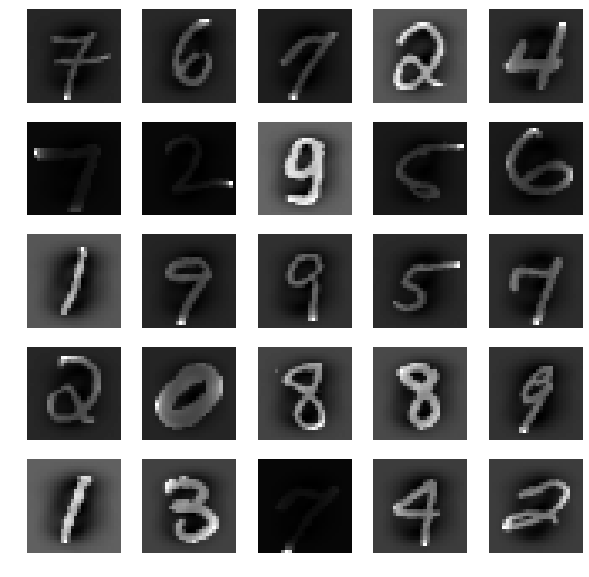

In [11]:
mn.setup()
mn.visualize()

Let's fit a `LogisticRegression` model and examine the coefficients $\Theta$

In [12]:
mnist_lr = mn.fit()

Example run in 4.219 s


/home/kjp/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


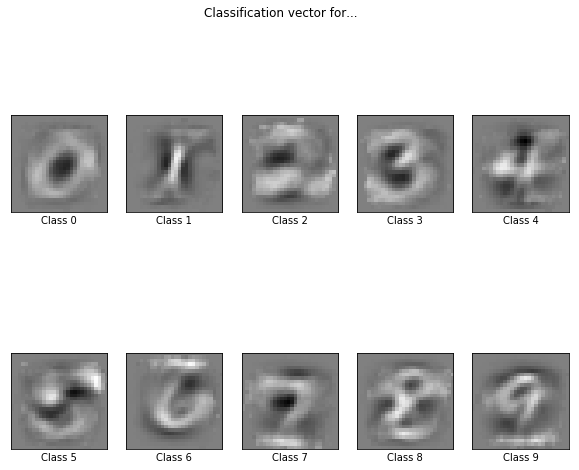

In [13]:
mnist_fig, mnist_ax = mn.plot_coeff()

# Gradient Descent



## Fitting a model

Our model (hypothesis) is written as

$
\hat{y^{(i)}} = h_\Theta(x^{(i)})
$

That is, our prediction for feature vector $x^{(i)}$ is a function with parameters $\Theta$.

**Model fitting** takes the training data and solves for $\Theta$.



Fitting most models usually involves the solution of an **Optimization Objective**.
- If we are minimizing: the optimization objective is called the **cost** function
- If we are maximizing: the optimization objective is called the **utility** function

The basic purpose of the optimization objective is to cause predictions to be close to the true values.
 

Let us denote

$
\text{error}^{(i)} = \hat{y^{(i)}} - y^{(i)}
$

So an Optimizaton Objective (Cost Function) that minimizes errors is one that seeks to make predictions close to true values.

There may be added elements (e.g., constraints) of the objective as well (discussed later). 

## Gradients

Gradient Descent is a method for optimizing the Optimization Objective.

It works for any model but we will illustrate it with Linear Regression.

For Linear Regression, the Cost Function is

$$
\begin{array}{lll}
\text{MSE}(X, \Theta) = {1 \over m} \sum_{i=1}^m { (\text{error}^{(i)} )^2}
\end{array}
$$

Recall that one way to minimize a Cost Function is to take derivatives with respect to $\Theta$ and set them to $0$.

Because $\Theta$ is a vector, there is one derivative per feature.
Hence the vector of derivatives (called the **gradient**) is

$
\nabla_{\boldsymbol{\theta}}\, \text{MSE}(X, \boldsymbol{\theta}) =
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(X, \boldsymbol{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(X, \boldsymbol{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(X, \boldsymbol{\theta})
\end{pmatrix}
$



$
\begin{array}{lll}
{ { \partial  }\over { \partial{ \theta_j} } } { \text{MSE}(X, \Theta) }& = & {1 \over m} \sum_{i=1}^m { \partial \over { \partial \theta_j } } { ( \text{error}^{(i)})^2 }\\
& = & {1 \over m} \sum_{i=1}^m { 2 \times \text{error}^{(i)} \times { \partial \over { \theta_j} }} {\text{error}^{(i)} }\\
& = & {2 \over m} \sum_{i=1}^m { \text{error}^{(i)} \times { \partial \over { \theta_j} }} { \hat{y^{(i)} } } \\
&= &  {2 \over m} \sum_{i=1}^m { \text{error}^{(i)} \times { x^{(i)}_j} }\\
\end{array}
$

For Linear Regression

$
\hat{y^{(i)}} =  \Theta^T \cdot x^{(i)} = \sum_{j=0}^n { \theta_j * x^{(i)}_j }
$

so

$
\text{error}^{(i)} = \Theta^T \cdot x^{(i)} - y^{(i)}
$

Thus the gradient for Linear Regression can be written in matrix form as

$
\nabla_{\boldsymbol{\theta}}\, \text{MSE}(X, \boldsymbol{\theta}) =
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

This will be particularly useful when working with NumPy as the gradient calculation is a vector operation that is implemented so as to be fast.

## Batch Gradient Descent

The basic algorithm is:
1. Initialize $\Theta$ randomly
1. Repeat until done
    1. Compute the Gradient
    1. Update $\Theta$ by taking a step in the (negative) direction of the Gradient

Let's illustrate Batch Gradient Descent on an example.

First, we use sklearn's `LinearRegression` as a baseline against which we will compare the $\Theta$ obtained from
Gradient Descent.

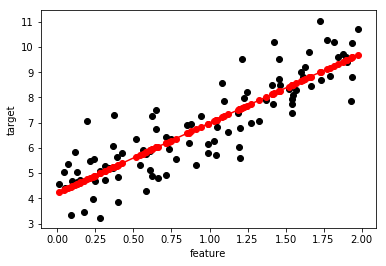

In [14]:
gd = tmh.GradientDescentHelper()

X_lr, y_lr = gd.gen_lr_data()
clf_lr = gd.fit_lr(X_lr,y_lr)
fig, ax = gd.plot_lr(X_lr, y_lr, clf_lr)

theta_lr = (clf_lr.intercept_, clf_lr.coef_)

Now let's perform Batch Gradient Descent and compare the $\Theta$'s

In [15]:
gd_theta = gd.batchGradientDescent_lr(X_lr, y_lr)
theta_lr - gd_theta

array([[ 7.99360578e-15],
       [-7.99360578e-15]])

The $\Theta$'s are equal up to 15 decimal points.

Let's look at the code for Batch Gradient Descent and examine the details

- You can see the code that implements the steps described in English
    - `eta` is the step size: how fast we adjust $\Theta$ in the direction of the gradient
    - `X_b` is the matrix
        - whose first column is $1$
        - whose other columns are the non-intercept features
    - `X_b.dot(theta)` are the predicted values for all observations
    - `X_b.dot(theta) - y` are the errors for all observations

Since the $\Theta$'s are the same, it's no surprise that the predictions are too.

In [16]:
X_new = np.array([[0], [2]])
gd_y_pred = gd.predict(X_new, theta_lr)
clf_y_pred = clf_lr.predict(X_new)

gd_y_pred == clf_y_pred

array([[ True],
       [ True]])

### Batch gradient descent: the movie

Let's watch Batch Gradient Descent at work

In [17]:
%%capture
movie_file = os.path.join(MOVIE_DIR,'batch_gradient_descent_eta_10.mp4')

if CREATE_MOVIE:
    gd_anim = gd.create_movie(X_lr, y_lr, n_iterations=10)
    gd_anim.save(movie_file, codec='h264')


In [18]:
if CREATE_MOVIE:
    gd.show_movie(gd_anim)
else:
    print("To view movie:\n Use link in following cell, or use browser to visit file {f}".format(f=movie_file))


To view movie:
 Use link in following cell, or use browser to visit file ./images/batch_gradient_descent_eta_10.mp4


[Movie](images/batch_gradient_descent_eta_10.mp4)

### Initializing $\Theta$
What would have happened if, instead of initializing $\Theta$ to random numbers we had initialized it to $0$ ?

### Step size

What's a good choice for `eta` ?  We had used 0.1 and obtained convergence in around 10 steps.

Le'ts try a smaller step size: `eta` = 0.2

In [19]:
%%capture
movie_file = os.path.join(MOVIE_DIR,'batch_gradient_descent_eta_02.mp4')

if CREATE_MOVIE:
    gd_anim_eta_02 = gd.create_movie(X_lr, y_lr, eta=0.02, n_iterations=30)
    gd_anim_eta_02.save(movie_file, codec='h264')


In [20]:
if CREATE_MOVIE:
    gd.show_movie(gd_anim_eta_02)
else:
    print("To view movie:\n Use link in following cell, or use browser to visit file {f}".format(f=movie_file))



To view movie:
 Use link in following cell, or use browser to visit file ./images/batch_gradient_descent_eta_02.mp4


[Movie](images/batch_gradient_descent_eta_02.mp4)

Like watching paint dry !

How about something bigger ?


In [21]:
%%capture
movie_file = os.path.join(MOVIE_DIR,'batch_gradient_descent_eta_45.mp4')
if CREATE_MOVIE:
    gd_anim_eta_45 = gd.create_movie(X_lr, y_lr, eta=0.45, n_iterations=20)
    gd_anim_eta_45.save(movie_file, codec='h264')


In [22]:
if CREATE_MOVIE:
    gd.show_movie(gd_anim_eta_45)
else:
    print("To view movie:\n Use link in following cell, or use browser to visit file {f}".format(f=movie_file))

To view movie:
 Use link in following cell, or use browser to visit file ./images/batch_gradient_descent_eta_45.mp4


[Movie](images/batch_gradient_descent_eta_45.mp4)

And even bigger

In [23]:
%%capture
movie_file = os.path.join(MOVIE_DIR,'batch_gradient_descent_eta_50.mp4')

if CREATE_MOVIE:
    gd_anim_eta_50 = gd.create_movie(X_lr, y_lr, eta=0.50, n_iterations=20)
    gd_anim_eta_50.save(movie_file, codec='h264')


In [24]:
if CREATE_MOVIE:
    gd.show_movie(gd_anim_eta_50)
else:
    print("To view movie:\n Use link in following cell, or use browser to visit file {f}".format(f=movie_file))

To view movie:
 Use link in following cell, or use browser to visit file ./images/batch_gradient_descent_eta_50.mp4


[Movie](images/batch_gradient_descent_eta_50.mp4)

Lost in space !

### Learning rate schedule

We see from the above that if the step size is too small, it takes long to converge.

But if the step size is too big, we may overshoot.

An adaptive learning rate schedule may be the solution:
- take big steps at first
- take smaller steps toward end


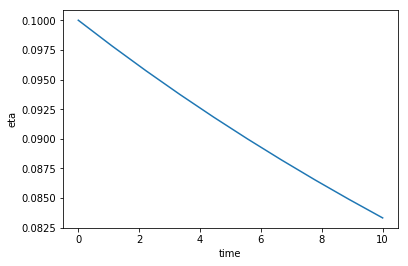

In [25]:
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

t = np.linspace(0, 10, 10)

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
_ =ax.plot(t, learning_schedule(t))
_ = ax.set_xlabel("time")
_ = ax.set_ylabel("eta")


### When to stop

Can we do better than running for a fixed number of iterations ?
Yes:
- Let $\text{Cost}_{t}$ be the Cpst Function at step $t$
- Stop if
    - $\text{Cost}_{t-1} - \text{Cost}_{t} < \epsilon $
    - That is: stop if improvement of Cost Function is not big enough

## Stochastic Gradient Descent

What is the computational complexity of Batch Gradient Descent (for Linear Regresssion_?

Can you spot the bottle-neck ?

$$ \nabla(j) = w^{(j)} + C \sum_{i=1}^n { \frac{\partial L(x_i, y_i)} {\partial w^{(j)}} }$$


Evaluating MSE (and the derivatives) involves iterating over all $m$ observations in the train dataset.

This can be quite large and hence slow.


Stochastic Gradient Descent evaluates the gradient at a single, randomly chosen point

$$ \nabla(j,i) = w^{(j)} + C { \frac{\partial L(x_i, y_i)} {\partial w^{(j)}} }$$

- so takes lots of steps
- each pass through $m$ observations is called an **epoch**

### Minbatch Gradient Descent

Our original  Batch Gradient Descent examined all $m$ observatons in the training set in order to
compute the exact value of the derivatives.

Stocahstic Gradient Descent evaluated the derivative at a single point.
- this can be quite noisy

We can get a pretty good, less-noisy estimate of the derivatives by examining a **batch** of observations whose size is more than 1 but fewer than $m$.

This is called Minibatch Gradient Descent

Observe that Batch Gradient Descent (our original attempt) is Minibatch Gradient Descent with `minibatch_size = 1`

## Other cost functions

- Ridge Regression Cost Function
    - MSE, with a penalty large $\Theta$
        - it's easy to compute the derivative of this cost function
        - try Minibatch Gradient Descent on this Cost Functions



## A word on derivatives

Preview of part 2 of the course:
- the derivatives we used were *analytic* and not numerical approximations
- how can we automate calculation of analytic derivatives ?

# Cool cost functions
Neural Style Transfer

Given 
- a "Content" Image that you want to transform
- a "Style" Image (e.g., Van Gogh "Starry Night")
- Generate a New image that is the Content image redrawn in the style of the Style Image
    - [Gatys: A Neural Algorithm for Style](https://arxiv.org/abs/1508.06576)
    - [Fast Neural Style Transfer](https://github.com/jcjohnson/fast-neural-style)
    


## Content image
<img src=images/chicago.jpg width=500> 

## Style image
<img src=images/starry_night_crop.jpg width=500>

## Generated image
<img src=images/chicago_starry_night.jpg width=500> 


## Objective function ? Gradient Descent ?
- Style image, represented as a vector of pixels $\vec{a}$
- Content image, represented as a vector of pixels $\vec{p}$
- Generated image, represented as a vector of pixels $\vec{x}$

The Loss function (which we want to minimize by varying $\vec{x}$) has two parts

$$
\text{L} = \text{L}_{\text{content}}(\vec{p}, \vec{x}) + \text{L}_{\text{style}}(\vec{a}, \vec{x})
$$

- a Content Loss
    - measure of how different the New $\vec{x}$ is from original $\vec{p}$
- a Style Loss
    - measure of how different the "style" of New $\vec{x}$ is from style of $\vec{a}$
    

Key: defining what is "style" and similarity of style

# Cross entropy, KL divergence

A measure of distribution similarity

### Cost function for Logistic Regression

Consider a single observation with target $y$

We assign the following cost to our prediction $\hat{y}$

$$
\begin{array}{lll}
c(\theta) & = &
\left\{
{
    \begin{array}{ll}
    - \textrm{log}(\hat{p}) & \textrm{if } & y = 1 \\
    - \textrm{log}(1-\hat{p})     & \textrm{if } & y = 0 \\
    \end{array}
}
\right.
& = & - \left( y*\textrm{log}(\hat{p}) + (1-y) * \textrm{log}(1-\hat{p}) \right)
\end{array}
$$

and over the entire training set of size $m$

$$
J(\theta) = 
\frac{1}{m} 
\sum_{i=1}^m 
\left(
{ y^i * \textrm{log} (\hat{p}^i) + (1-y^i) * \textrm{log}(1-\hat{p}^i)}
\right)
$$

**Intuition**

- if $y^i = 1$
    - the second addend is 0
    - we want the first addend to be small. i.e.,
        - $\hat{p}^i$ to be $1$, so that $\textrm{log}( \hat{p}^i) = 0$
- if $y^i = 0$
    - the first addend is 0
        - we want the second addend to be small, i.e., 
            - $\hat{p}^i$ to be $0$, so that  $\textrm{log}( 1 - \hat{p}^i) = 0$

In [26]:
print("Done")

Done
